<center>
<img src="../../img/ods_stickers.jpg">

## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
    
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center>Assignment #2 (demo)
## <center>Analyzing cardiovascular disease data 
    
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data) + [solution](https://www.kaggle.com/kashnitsky/a2-demo-analyzing-cardiovascular-data-solution).**

In this assignment, you will answer questions about a dataset on cardiovascular disease. You do not need to download the data: it is already in the repository. There are some Tasks that will require you to write code. Complete them and then answer the questions in the [form](https://docs.google.com/forms/d/13cE_tSIb6hsScQvvWUJeu1MEHE5L6vnxQUbDYpXsf24).

#### Problem

Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

First, we will initialize the environment:

In [1]:
# Import all required modules
# Disable warnings
import warnings

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

# Import plotting modules and set up
import seaborn as sns

sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
df = pd.read_csv("../../data/mlbootcamp5_train.csv", sep=";")
print("Dataset size: ", df.shape)
df.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


It would be instructive to peek into the values of our variables.
 
Let's convert the data into *long* format and depict the value counts of the categorical features using [`factorplot()`](https://seaborn.pydata.org/generated/seaborn.factorplot.html).

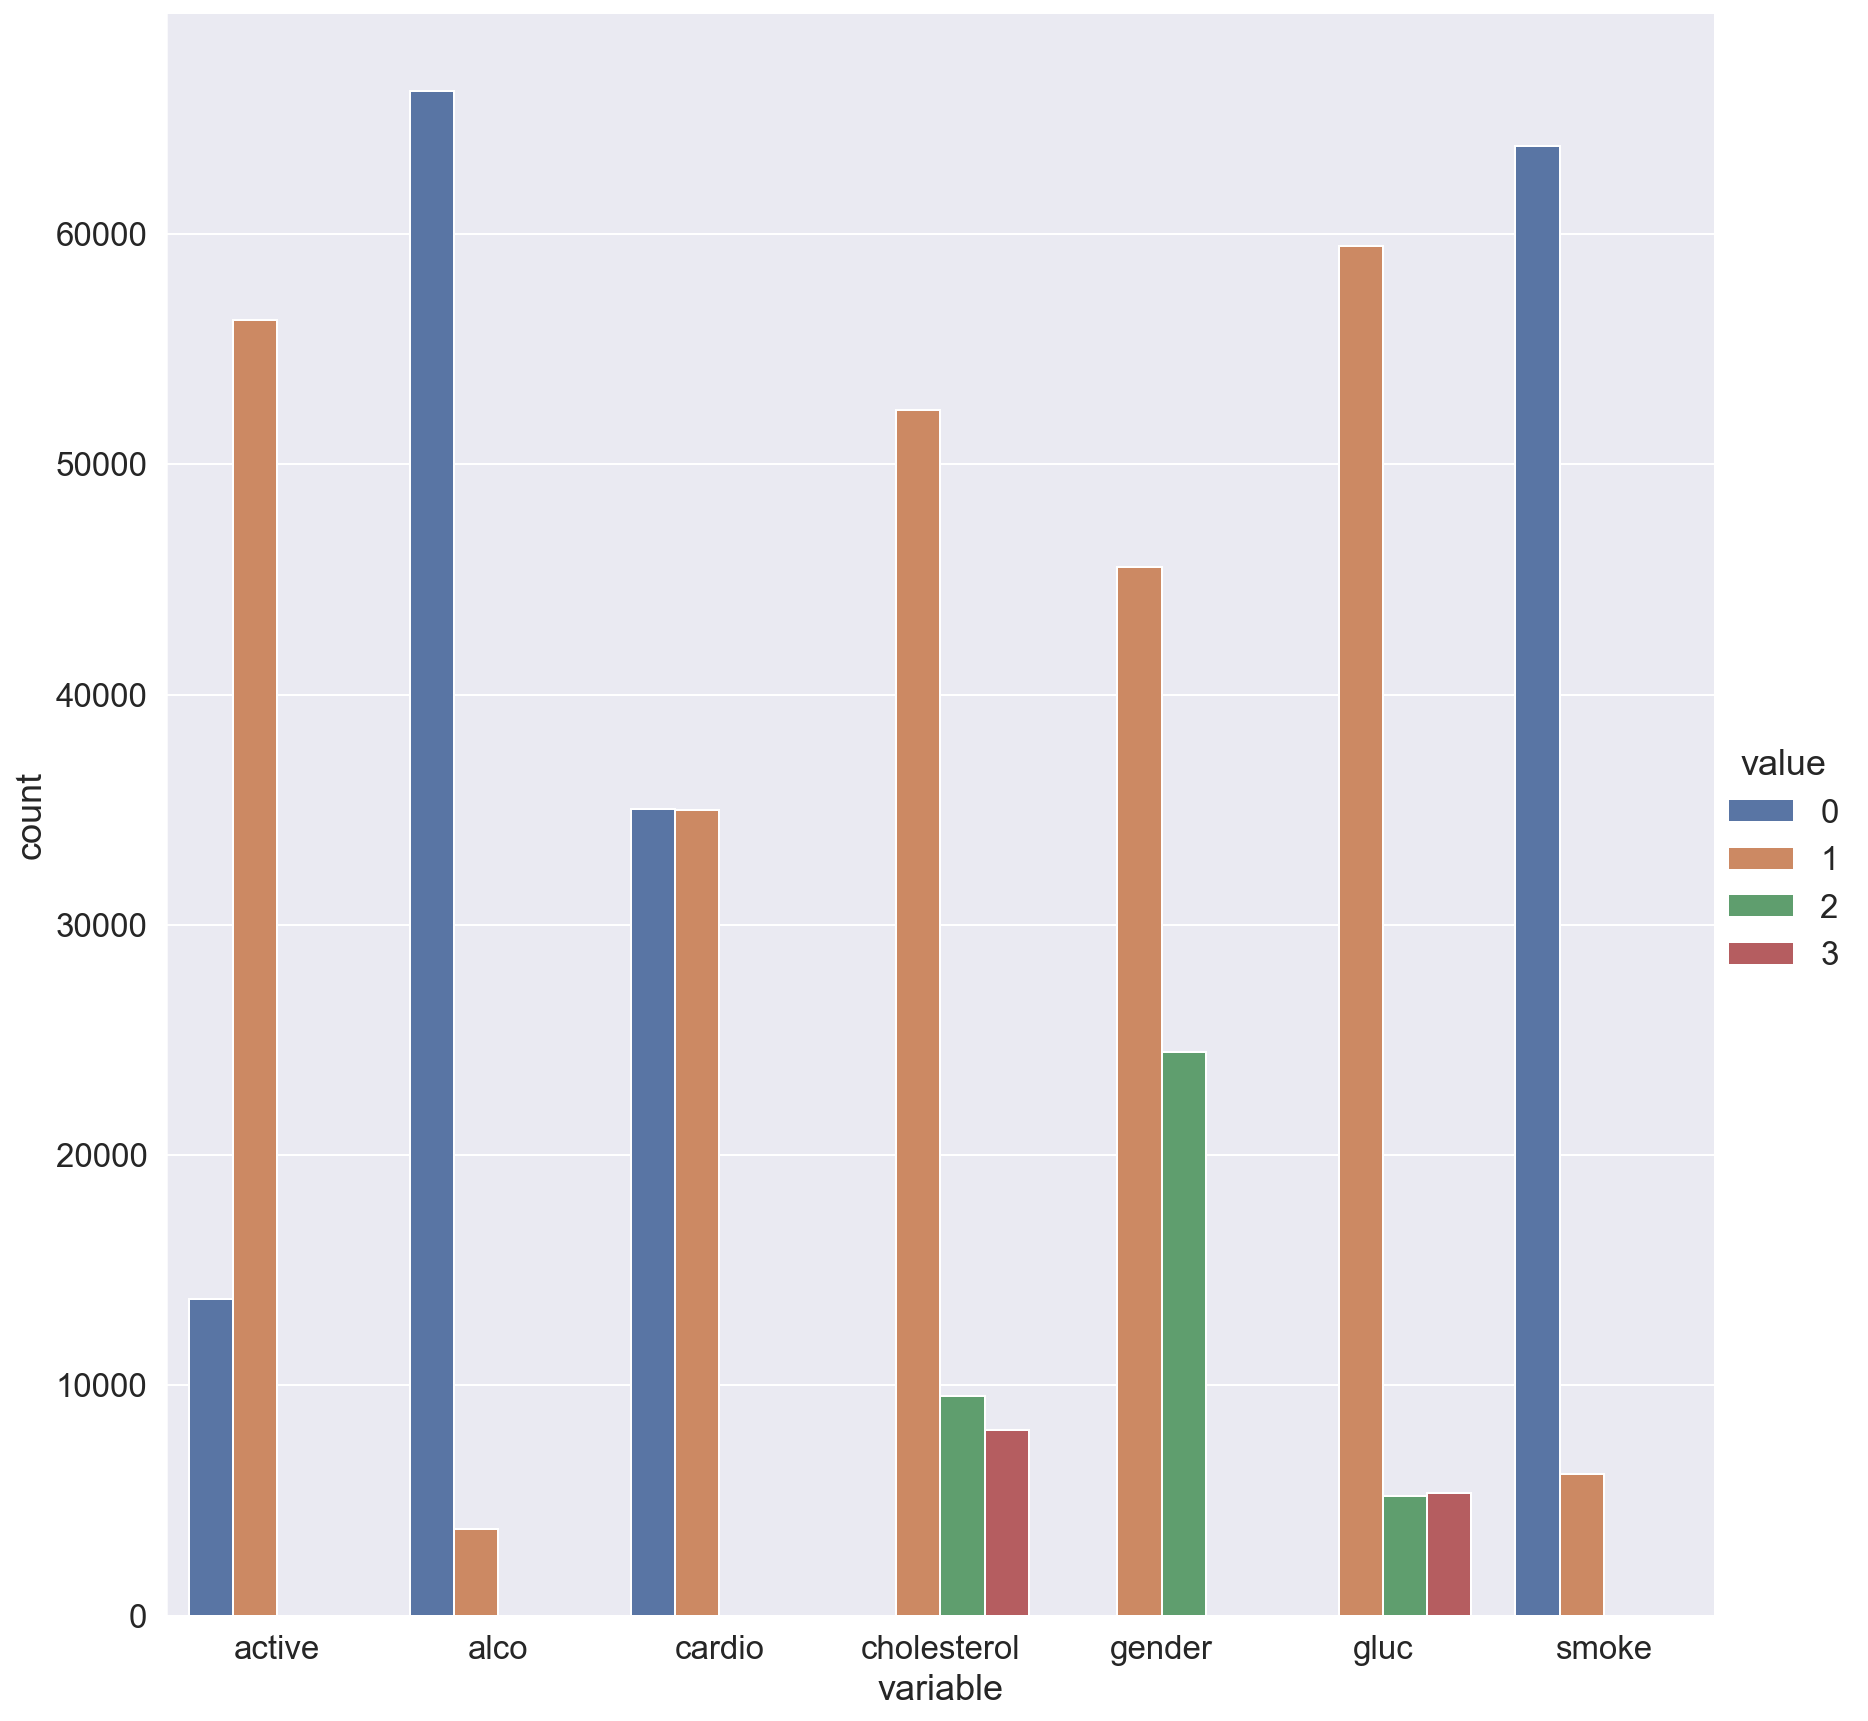

In [4]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", size=12
);

We can see that the target classes are balanced. That's great!

Let's split the dataset by target values. Can you already spot the most significant feature by just looking at the plot?

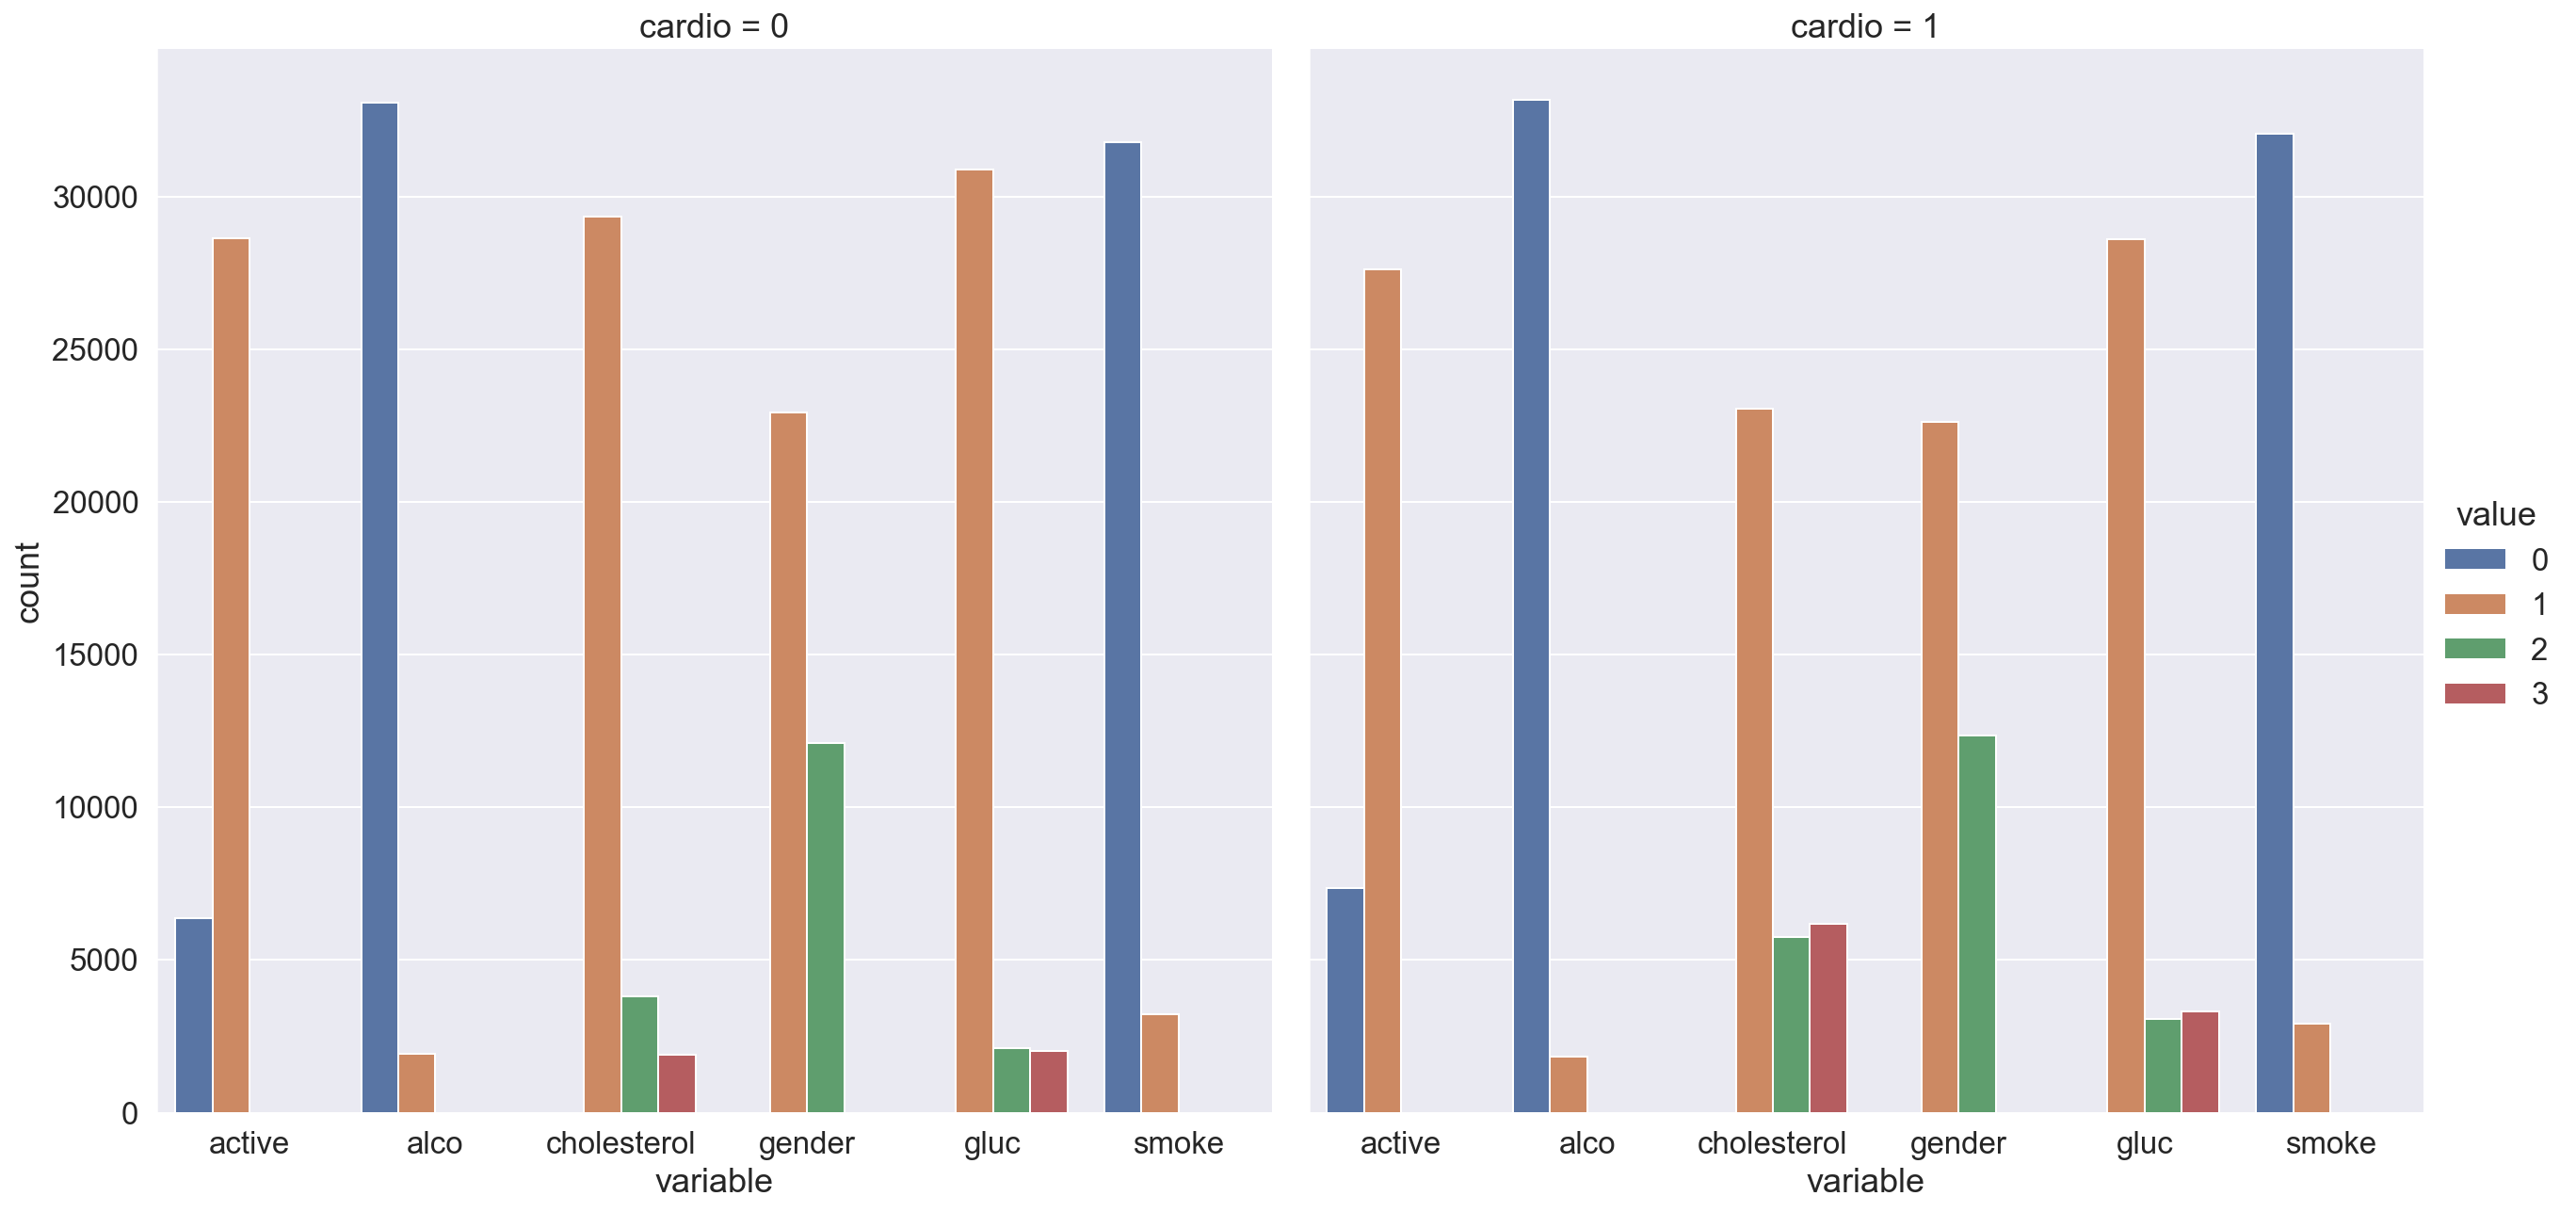

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    size=9,
);

You can see that the distribution of cholesterol and glucose levels great differs by the value of the target variable. Is this a coincidence?

Now, let's calculate some statistics for the feature unique values:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


In the end, we have:
- 5 numerical features (excluding *id*);
- 7 categorical features;
- 70000 records in total.

## 1.1. Basic observations

**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average. **
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

In [7]:
# First one is to see the gender distribution (even though we know it from the above calculations)
df["gender"].value_counts().to_frame()

,gender
1,45530
2,24470


In [8]:
#Looking for average height of particular gender

for i in range(1,3):
    print(df[df["gender"] == i]["height"].mean())

### It was stated, that men are taller, thus
### => 2 are men and 1 are women

161.35561168460356
169.94789538210054


**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

In [9]:
for i in range(1,3):
    if i == 1:
        print("--------> Women")
    else:
        print("--------> Man")
    print(df[df["gender"] == i]["alco"].value_counts().to_frame())
    print(df[df["gender"] == i]["alco"].mean())


### => men

--------> Women
    alco
0  44369
1   1161
0.02549967054689216
--------> Man
    alco
0  21867
1   2603
0.10637515324887617


**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [10]:
for i in range(1,3):
    print((df[df["gender"] == i][df["smoke"]==1]["smoke"].count())/df[df["gender"] == i].shape[0])


### => 20% difference

0.017856358444981332
0.21888026154474868


**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.**

1. 5
2. 10
3. 15
4. 20

In [11]:
yt = df.groupby("smoke")["age"].median()

In [12]:
yt

smoke
0    19722
1    19125
Name: age, dtype: int64

In [13]:
yt = yt/365

In [14]:
yt

smoke
0    54.032877
1    52.397260
Name: age, dtype: float64

In [15]:
((df[df["smoke"] == 0]["age"].median() - df[df["smoke"] == 1]["age"].median()) / 365) * 12

### => almost 20 month

19.627397260273973

## 1.2. Risk maps
### Task:

On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years. Here it is:
<img src='../../img/SCORE_CVD_eng.png' width=70%>

Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180).

Let's calculate that same ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [16]:
# Just creating new feature with years (full)
df["age_years"] = (df["age"] / 365).round().astype("int")

In [17]:
df["age_years"].max()

65

In [18]:
### Men, 60-64, smoking
men_smoking_senior = df[(df["gender"] == 2) & (df["smoke"] == 1) & (df["age_years"] >= 60) & (df["age_years"] < 65)]

In [19]:
men_smoking_senior.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
19,29,21755,2,162,56.0,120,70,1,1,1,0,1,0,60
38,52,23388,2,162,72.0,130,80,1,1,1,0,1,1,64
67,90,22099,2,171,97.0,150,100,3,1,1,0,1,1,61
177,240,21848,2,170,69.0,120,80,1,1,1,1,1,0,60
182,248,22671,2,174,74.0,130,80,3,1,1,0,1,1,62


In [20]:
denominator = men_smoking_senior[(men_smoking_senior["cholesterol"] == 1) 
                               & (men_smoking_senior["ap_hi"] < 120)]["cardio"].mean()
print(denominator)

0.2564102564102564


In [21]:
numerator = men_smoking_senior[(men_smoking_senior["cholesterol"] == 3) & (men_smoking_senior["ap_hi"] >= 160) 
                       & (men_smoking_senior["ap_hi"] < 180)]["cardio"].mean()
print(numerator)

0.8636363636363636


In [22]:
round(numerator / denominator)

3

**Question 1.5. (2 points). Calculate the fraction of the people with CVD for the two segments described above. What is the ratio of these two fractions?**

1. 1
2. 2
3. 3
4. 4

In [23]:
### => .86/.26 = 3

## 1.3. Analyzing BMI
### Task:

Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [24]:
# Another new feature, float due to the requirements
df["BMI"] = (df["weight"] /( (df["height"]/100)**2)).round(1).astype("float")

In [25]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53,26.9
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,62,50.5
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52,31.4
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.1


**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values.
2. The BMI for women is on average higher than for men.
3. Healthy people have, on average, a higher BMI than the people with CVD.
4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [26]:
#Median BMI in the sample is within the range of normal BMI values.
print(df["BMI"].median()) ### No, exceeds

26.4


In [27]:
#The BMI for women is on average higher than for men.

#df.groupby("gender")["BMI"].mean().to_frame() ###Yes

#So, median should be used
df.groupby("gender")["BMI"].median().to_frame()

,BMI
gender,
1,26.7
2,25.9


In [28]:
#Healthy people have, on average, a higher BMI than the people with CVD.

#df.groupby("cardio")["BMI"].mean().to_frame() ###No

#So, median should be used
df.groupby("cardio")["BMI"].median().to_frame()

,BMI
cardio,
0,25.5
1,27.5


In [29]:
#For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women
for i in range(1,3):
    print(df[(df["cardio"]  == 0) & (df["gender"]  == i) & (df["alco"]  == 0) ]["BMI"].median())

### True

25.7
25.1


## 1.4. Cleaning data

### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [30]:
# You code here
dirty_data = df[(df["ap_lo"] > df["ap_hi"])
               | (df["height"] < df["height"].quantile(0.025))
               | (df["height"] > df["height"].quantile(0.975))
               | (df["weight"] < df["weight"].quantile(0.025))
               | (df["weight"] > df["weight"].quantile(0.975))
               ]

In [31]:
dirty_data["id"].count()/df["id"].count()

### Which is 10%

0.0963

In [32]:
dirty_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
14,23,14532,2,181,95.0,130,90,1,1,1,1,1,0,40,29.0
15,24,16782,2,172,112.0,120,80,1,1,0,0,0,1,46,37.9
23,33,23376,2,156,45.0,110,60,1,1,0,0,1,0,64,18.5
44,59,19764,1,154,50.0,170,80,3,1,0,0,1,1,54,21.1
62,81,20330,2,187,115.0,130,90,1,1,0,1,1,0,56,32.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69975,99963,21264,2,182,100.0,120,80,1,1,0,0,1,1,58,30.2
69981,99972,17500,2,182,110.0,130,90,2,2,0,0,1,1,48,33.2
69987,99979,18852,1,151,49.0,120,80,1,1,0,0,1,0,52,21.5
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,62,50.5


In [33]:
df['id'].value_counts().sum()
### so, id is a unique parameter indeed, thus can be used for dropping the data

70000

In [34]:
cond = df['id'].isin(dirty_data['id'])
df.drop(df[cond].index, inplace = True)

In [35]:
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,52,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,48,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69993,99991,19699,1,172,70.0,130,90,1,1,0,0,1,1,54,23.7
69994,99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,58,29.4
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,53,26.9
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,61,27.1


**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8
2. 9
3. 10
4. 11

# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

In [36]:
sns.heatmap?

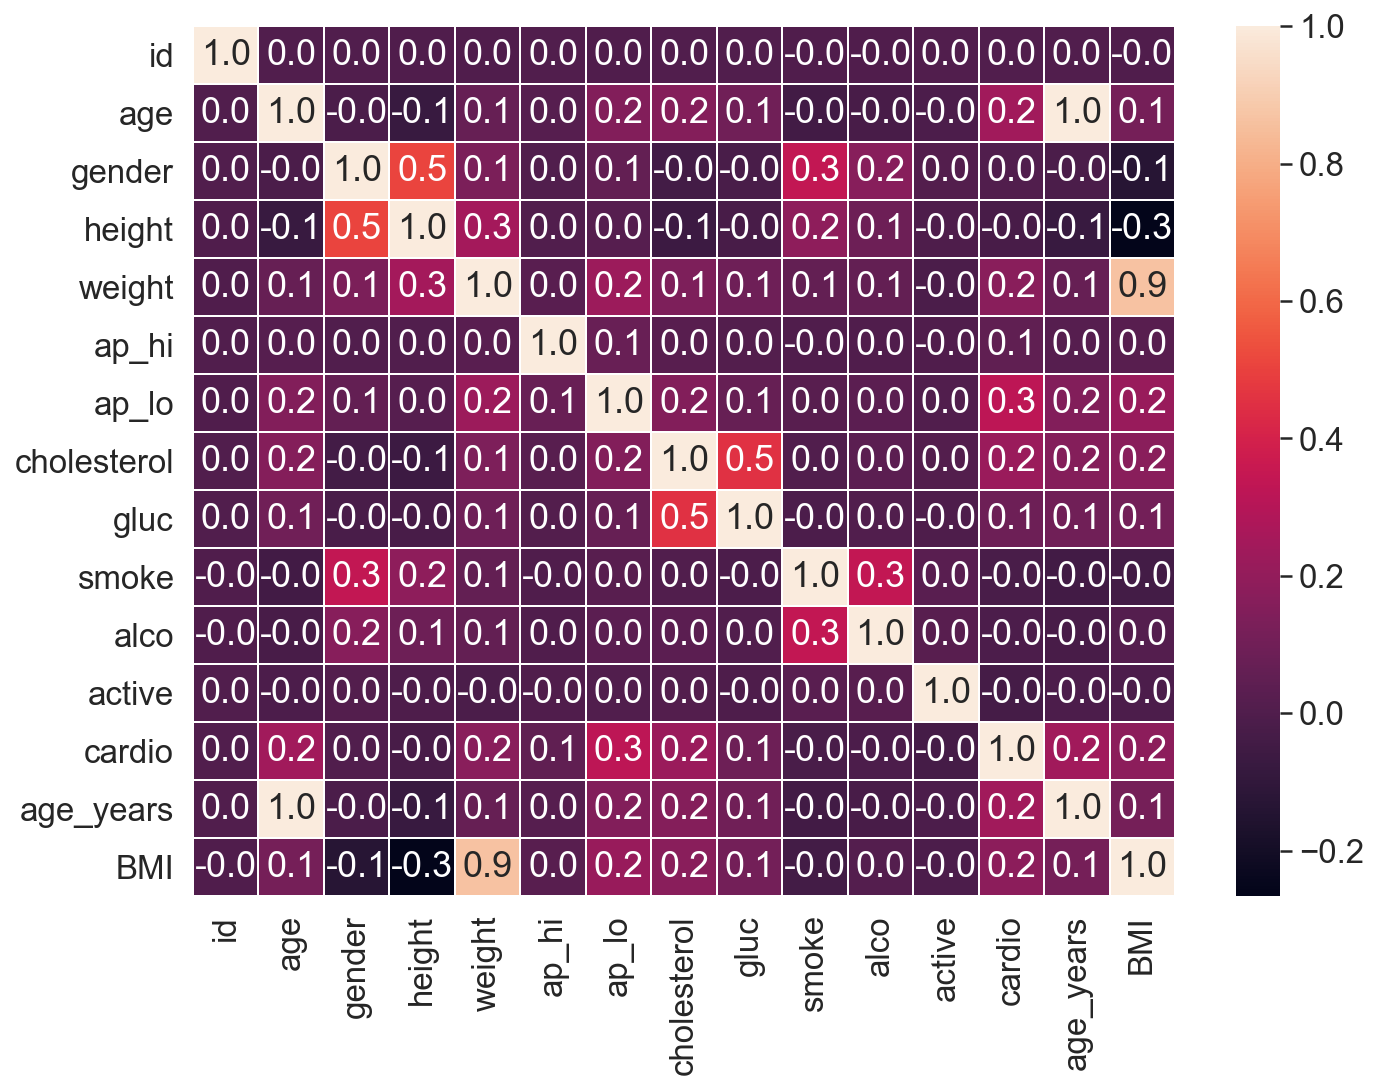

In [37]:
# You code here
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".1f", linewidths=1.0);

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol
2. Height, Smoke
3. Smoke, Alco
4. Height, Weight

In [38]:
print("1st pair ", corr["gender"]["cholesterol"], corr["gender"]["cardio"])
print("2nd pair ", corr["gender"]["height"], corr["gender"]["smoke"])
print("3rd pair ", corr["gender"]["smoke"], corr["gender"]["alco"])
print("4th pair ", corr["gender"]["height"], corr["gender"]["weight"])

1st pair  -0.038817054378150175 0.0023486846101276513
2nd pair  0.5064466549309252 0.3378550523630206
3rd pair  0.3378550523630206 0.16888747998330467
4th pair  0.5064466549309252 0.13019299064748735


In [39]:
### => 2

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

In [40]:
pd.melt?

In [41]:
# So, getting new dataframe with "long" data format
new_df = pd.melt(frame = df, value_vars = ['height'], id_vars = ['gender'])

In [42]:
new_df

,gender,variable,value
0,2,height,168
1,1,height,156
2,1,height,165
3,2,height,169
4,1,height,156
...,...,...,...
63254,1,height,172
63255,1,height,165
63256,2,height,168
63257,1,height,163


In [43]:
sns.violinplot?

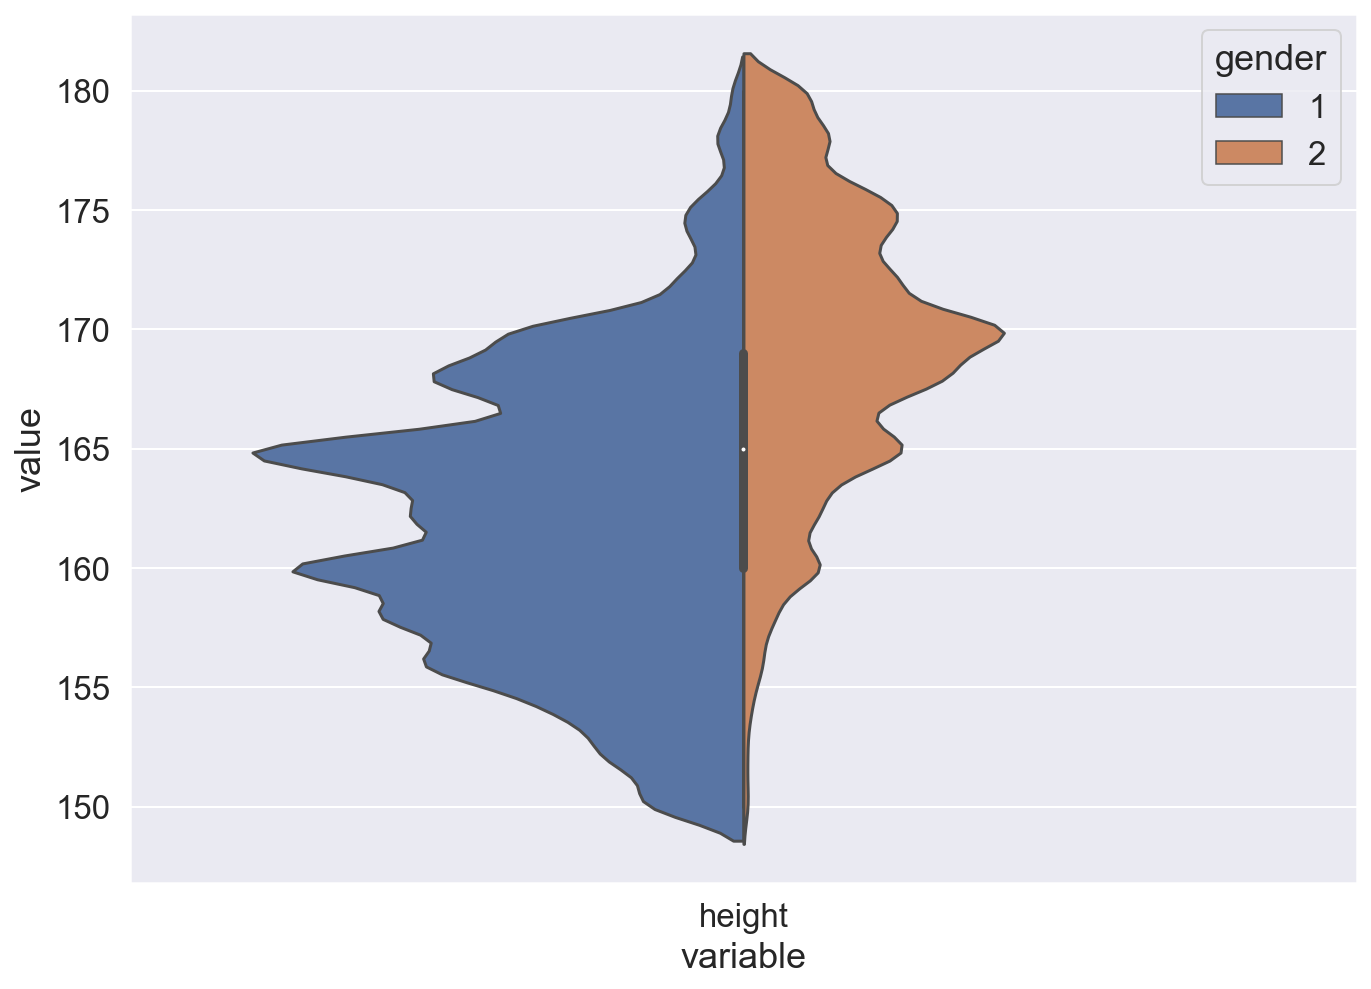

In [44]:
sns.violinplot(x = "variable", y = "value", hue = "gender", data = new_df, 
               split=True, scale="count", scale_hue=False);

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight
2. Age, Weight
3. Cholesterol, Gluc
4. Cardio, Cholesterol
5. Ap_hi, Ap_lo
6. Smoke, Alco

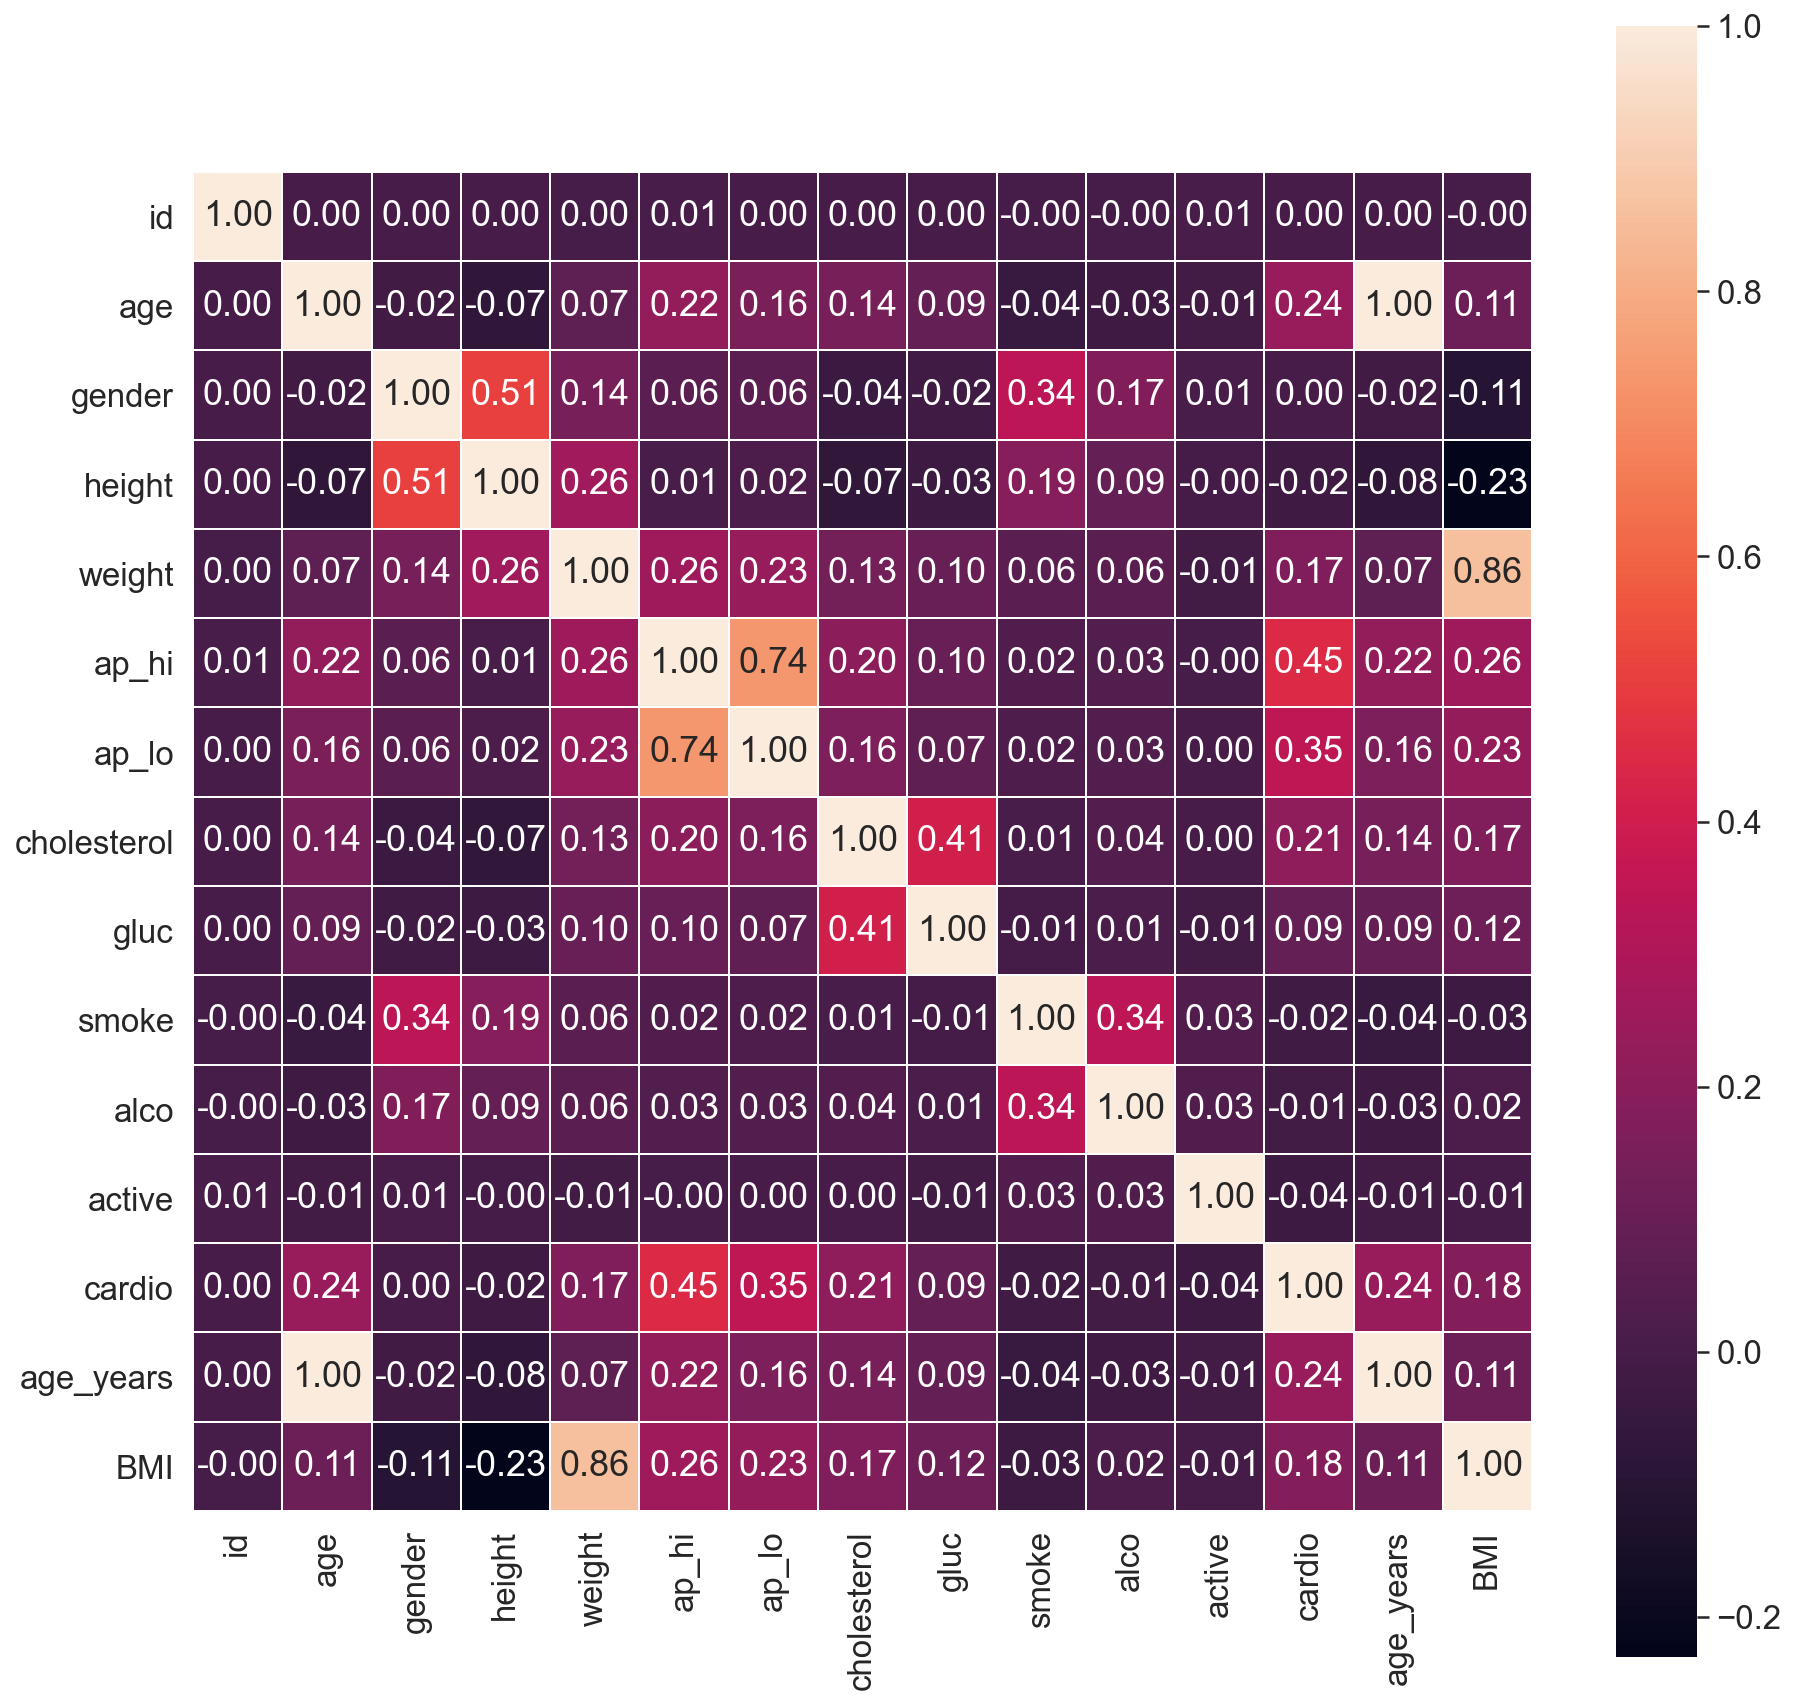

In [45]:
corr_spearman = df.corr(method="spearman")
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr_spearman, annot=True, fmt=".2f", linewidths=1.0, square=True);

In [46]:
print("1st pair ", corr_spearman["height"]["weight"])
print("2nd pair ", corr_spearman["age"]["weight"])
print("3rd pair ", corr_spearman["cholesterol"]["gluc"])
print("4th pair ", corr_spearman["cardio"]["cholesterol"])
print("5th pair ", corr_spearman["ap_hi"]["ap_lo"])
print("6th pair ", corr_spearman["smoke"]["alco"])

1st pair  0.26253065958215827
2nd pair  0.0703639958912695
3rd pair  0.4076454259722647
4th pair  0.21281450975507588
5th pair  0.7362078044226716
6th pair  0.34120042542324364


## 2.3. Rank correlation

In most cases, *the Pearson coefficient of linear correlation* is more than enough to discover patterns in data. 
But let's go a little further and calculate a [rank correlation](https://en.wikipedia.org/wiki/Rank_correlation). It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

### Task:

Calculate and plot a correlation matrix using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).



In [47]:
# You code here
corr_spearman

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
id,1.000000,0.001721,0.003727,0.000802,0.000634,0.005825,0.001021,0.004494,0.002312,-0.002741,-0.000716,0.005914,0.003899,0.001478,-0.000633
age,0.001721,1.000000,-0.015222,-0.073573,0.070364,0.221739,0.158349,0.140324,0.090955,-0.044066,-0.027289,-0.011838,0.237033,0.998044,0.107945
gender,0.003727,-0.015222,1.000000,0.510813,0.141272,0.059131,0.059237,-0.038729,-0.021881,0.337855,0.168887,0.007791,0.002349,-0.015729,-0.106027
height,0.000802,-0.073573,0.510813,1.000000,0.262531,0.005737,0.015586,-0.066984,-0.031342,0.187564,0.088116,-0.004826,-0.023685,-0.075043,-0.229960
weight,0.000634,0.070364,0.141272,0.262531,1.000000,0.257434,0.231913,0.133133,0.100072,0.060794,0.060163,-0.011813,0.168049,0.071877,0.858597
ap_hi,0.005825,0.221739,0.059131,0.005737,0.257434,1.000000,0.736208,0.204520,0.097666,0.024877,0.030566,-0.000420,0.447185,0.223314,0.256702
ap_lo,0.001021,0.158349,0.059237,0.015586,0.231913,0.736208,1.000000,0.162013,0.074264,0.022317,0.033251,0.004430,0.350219,0.159580,0.226615
cholesterol,0.004494,0.140324,-0.038729,-0.066984,0.133133,0.204520,0.162013,1.000000,0.407645,0.010230,0.036269,0.004398,0.212815,0.142065,0.167723
gluc,0.002312,0.090955,-0.021881,-0.031342,0.100072,0.097666,0.074264,0.407645,1.000000,-0.005629,0.012451,-0.009680,0.089192,0.090762,0.117123
smoke,-0.002741,-0.044066,0.337855,0.187564,0.060794,0.024877,0.022317,0.010230,-0.005629,1.000000,0.341200,0.026940,-0.020345,-0.044027,-0.029407


**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors).
2. Relation is wrong, these features should not be related.
3. Nature of the data.

In [48]:
#Well, I guess they shoud be related, thus => 3 

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.

### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

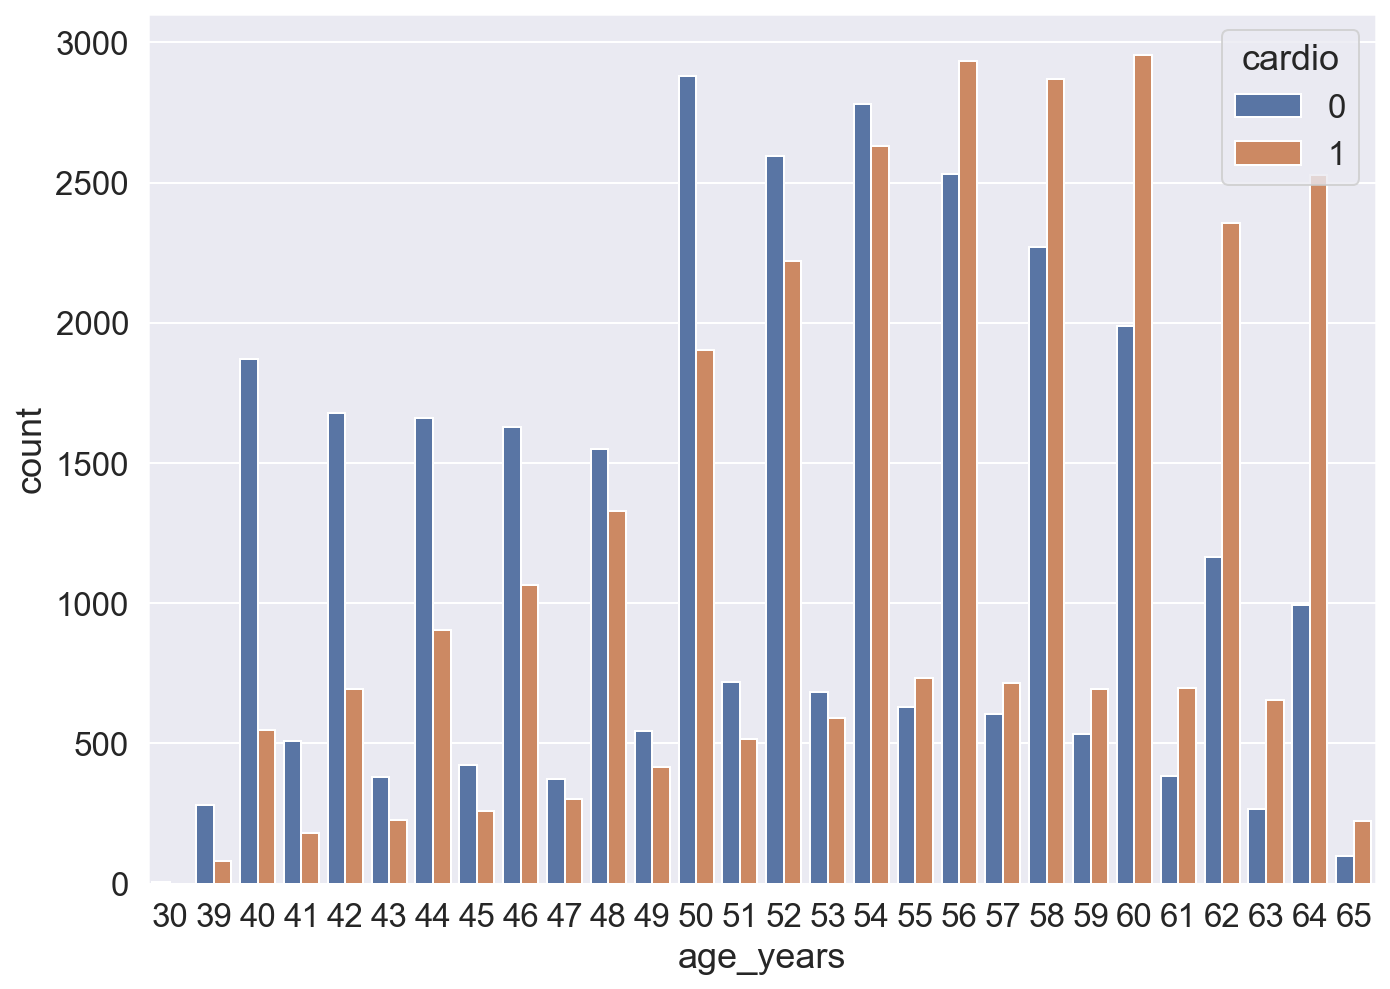

In [49]:
# Ordinary countplot
sns.countplot(x = 'age_years', hue = 'cardio', data = df);

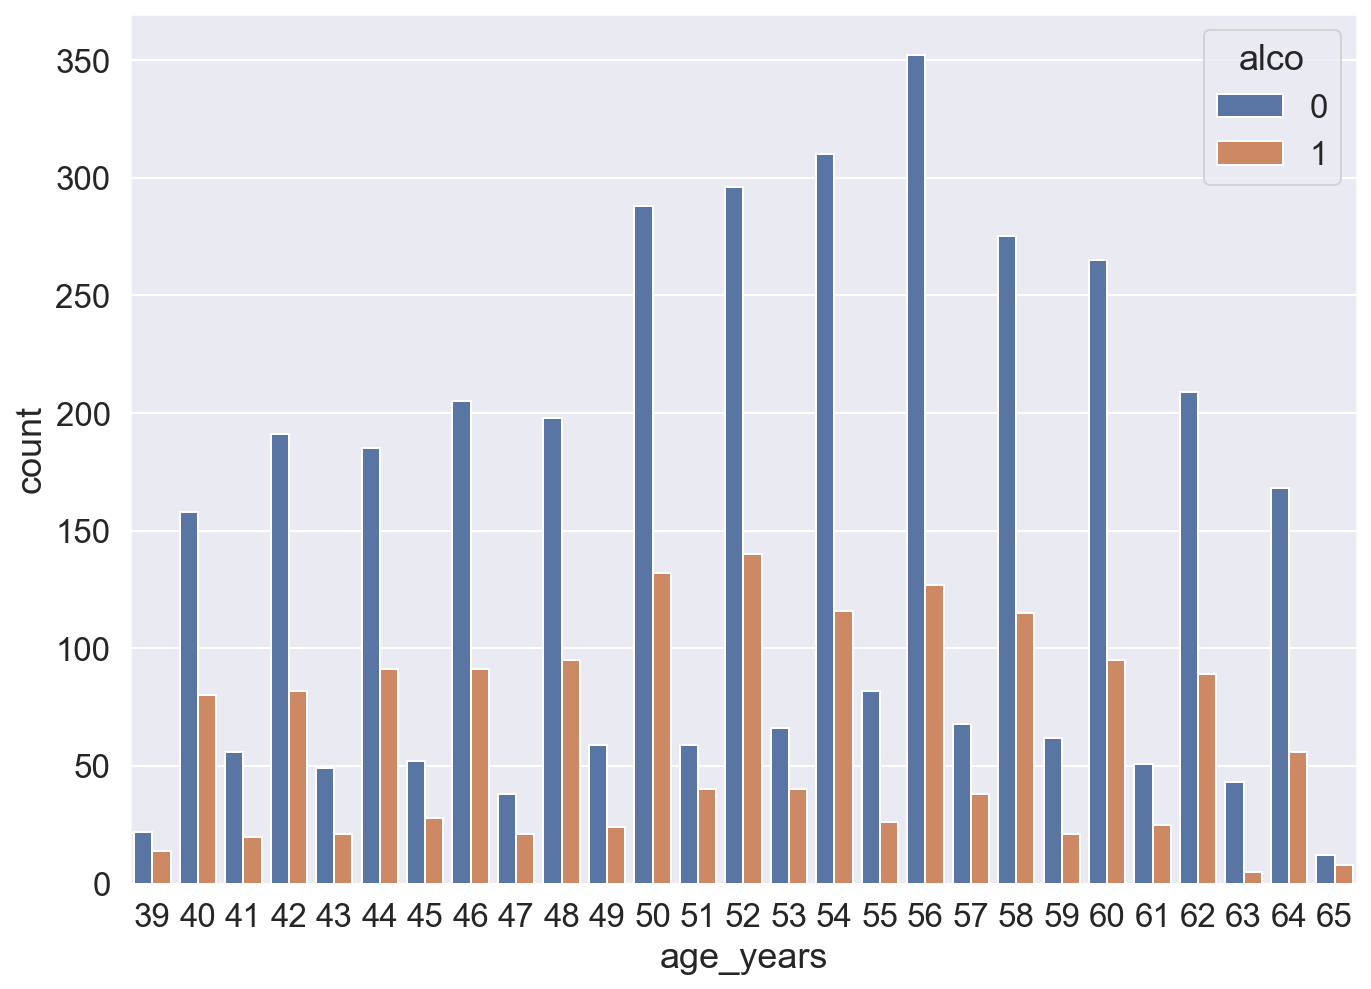

In [50]:
sns.countplot(x = 'age_years', hue = 'alco' , data = df[df["smoke"] == 1]);

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44
2. 55
3. 64
4. 70

In [51]:
### Visual analysis is good, but numeric is better
for x in sorted(df["age_years"].unique()):
    print("age: ", x)

    if (df[(df["age_years"] == x) & (df["cardio"] == 0)].shape[0] 
        - df[(df["age_years"] == x) & (df["cardio"] == 1)].shape[0]) > 0:
        print("False")
    else:
        print("True")
        break
        
### Still it is 55

age:  30
False
age:  39
False
age:  40
False
age:  41
False
age:  42
False
age:  43
False
age:  44
False
age:  45
False
age:  46
False
age:  47
False
age:  48
False
age:  49
False
age:  50
False
age:  51
False
age:  52
False
age:  53
False
age:  54
False
age:  55
True
